## Anomaly Detection in ECG data

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from typing import List, Tuple
from torch.utils.data import Dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [119]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Datasets creation

- training data

In [120]:
with open('ECG5000/ECG5000_TRAIN.arff', 'r') as f:
    arff_file = arff.loadarff(f)
    df_train = pd.DataFrame(arff_file[0])
    
df_train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,b'1'
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,b'1'
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,b'1'
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,b'1'
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,b'1'


In [121]:
print(df_train.shape)
print(df_train.describe())

(500, 141)
             att1        att2        att3        att4        att5        att6  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean    -0.159100   -1.551951   -2.442733   -3.098292   -3.177269   -2.899259   
std      1.140292    1.416321    1.400143    1.325583    1.128045    0.904602   
min     -3.694197   -5.117621   -5.110389   -5.060774   -5.375715   -5.056184   
25%     -0.928707   -2.644930   -3.617218   -4.251520   -4.022823   -3.537361   
50%     -0.216883   -1.539340   -2.513000   -3.309532   -3.541513   -3.008340   
75%      0.582008   -0.595632   -1.448769   -2.199136   -2.546305   -2.432860   
max      4.058127    2.087844    1.592974    1.423006    1.014557    0.610640   

             att7        att8        att9       att10  ...      att131  \
count  500.000000  500.000000  500.000000  500.000000  ...  500.000000   
mean    -2.286133   -1.800159   -1.429717   -0.948419  ...    0.146861   
std      0.697134    0.575725    0.58

- test data

In [122]:
with open('ECG5000/ECG5000_TEST.arff', 'r') as f:
    arff_file = arff.loadarff(f)
    df_test = pd.DataFrame(arff_file[0])
    
print(df_test.head())
print(df_test.shape)

       att1      att2      att3      att4      att5      att6      att7  \
0  3.690844  0.711414 -2.114091 -4.141007 -4.574472 -3.431909 -1.950791   
1 -1.348132 -3.996038 -4.226750 -4.251187 -3.477953 -2.228422 -1.808488   
2  1.024295 -0.590314 -1.916949 -2.806989 -3.527905 -3.638675 -2.779767   
3  0.545657 -1.014383 -2.316698 -3.634040 -4.196857 -3.758093 -3.194444   
4  0.661133 -1.552471 -3.124641 -4.313351 -4.017042 -3.005993 -1.832411   

       att8      att9     att10  ...    att132    att133    att134    att135  \
0 -1.107067 -0.632322  0.334577  ...  0.022847  0.188937  0.480932  0.629250   
1 -1.534242 -0.779861 -0.397999  ...  1.570938  1.591394  1.549193  1.193077   
2 -2.019031 -1.980754 -1.440680  ...  0.443502  0.827582  1.237007  1.235121   
3 -2.221764 -1.588554 -1.202146  ...  0.777530  1.119240  0.902984  0.554098   
4 -1.503886 -1.071705 -0.521316  ...  1.280823  1.494315  1.618764  1.447449   

     att136    att137    att138    att139    att140  target  
0  0.5

- combine train and test data (unsupervised learning) 

In [123]:
data = pd.concat([df_train, df_test], axis=0)
print(data.shape)

(5000, 141)


In [124]:
CLASS_NORMAL = b'1'

class_names = ['Normal', 'R on T', 'PVC', 'SP', 'UB']

print(data['target'].unique())

[b'1' b'2' b'3' b'4' b'5']


- data preprocessing

In [125]:
data['target'].value_counts()

target
b'1'    2919
b'2'    1767
b'4'     194
b'3'      96
b'5'      24
Name: count, dtype: int64

In [126]:
# shuffle
data = data.sample(frac=1).reset_index(drop=True)

In [127]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
    '''
    plots a time series along with a shaded area representing the standard deviation.

    Parameters:
    - data (array-like): Time series data (e.g., list, NumPy array, or DataFrame).
    - class_name (str): Name of the class/series, used as the plot title.
    - ax (matplotlib.axes.Axes): The axis object on which the plot will be drawn.
    - n_steps (int, optional): Rolling window size for calculating the mean and standard deviation. Default is 10.

    Plot:
    - Solid line: Rolling mean of the time series.
    - Shaded area: Standard deviation interval (mean ± 2 * standard deviation). 
    '''
    time_series_df = pd.DataFrame(data)
    
    path = time_series_df.rolling(n_steps, min_periods=1).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps, min_periods=1).std()
    
    path = path.iloc[:, 0]
    path_deviation = path_deviation.iloc[:, 0]
    
    under_line = (path - path_deviation).values
    over_line = (path + path_deviation).values
    
    ax.plot(path, linewidth=2, label=class_name)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=0.125,
        color='blue'  
    )
    ax.set_title(class_name)
    ax.legend()

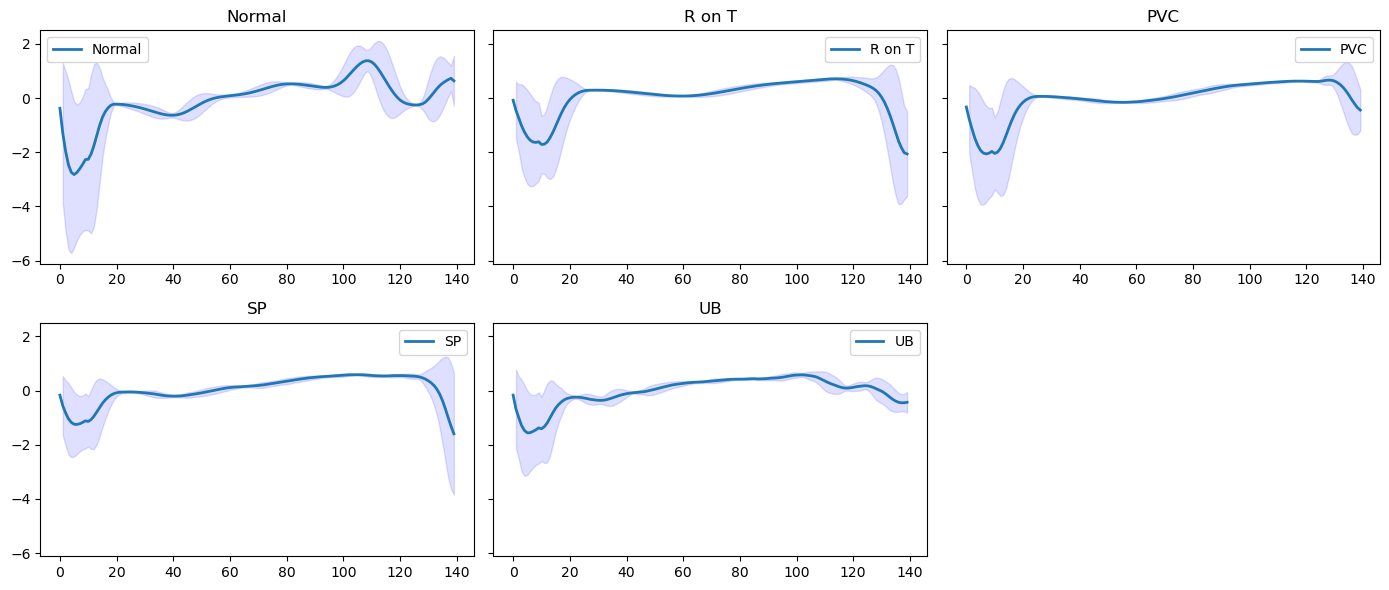

In [128]:
classes = data['target'].unique()

fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 6)
)

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    
    temp_data = data[data['target'] == cls].drop(labels='target', axis=1).mean(axis=0).to_numpy()
    
    plot_time_series_class(temp_data, class_names[i], ax)

fig.delaxes(axs.flat[-1])

fig.tight_layout()
plt.show()

- normalization:

In [129]:
target_column = data.iloc[:, -1] 
features = data.iloc[:, :-1]  

scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

normalized_data = pd.DataFrame(normalized_features, columns=features.columns)
normalized_data['target'] = target_column.values 

normalized_data.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.449445,-0.647018,-0.947970,-1.120072,-0.846996,-0.180659,0.601515,0.435607,0.647113,0.940599,...,0.975432,0.775143,0.743074,0.723700,0.684117,0.656323,0.671935,0.965305,1.043058,b'1'
1,0.071370,-0.109105,-0.797532,-0.997277,-0.882374,-0.571138,-0.216358,0.052534,-0.317042,-0.110533,...,0.994782,1.114557,1.246301,1.187586,0.999348,0.732372,0.586151,0.489267,-0.057944,b'1'
2,0.068869,-0.854978,-0.930812,-0.780225,-0.403699,-0.033829,0.485564,0.273868,0.217067,0.484949,...,0.774373,0.868765,1.008296,0.975199,0.897389,0.928099,1.125228,1.377904,0.653709,b'1'
3,-0.820766,-0.830074,-0.553390,-0.597158,-0.643804,-0.348201,0.614615,0.747710,0.572489,0.993204,...,0.958476,0.482115,0.107411,-0.309390,-0.664743,-0.816143,-0.760379,-0.369583,-0.951540,b'1'
4,-0.110919,-0.707134,-0.883371,-0.713976,-0.601639,-0.743352,-0.602765,0.065330,0.105460,-0.201370,...,0.931860,0.907013,0.796131,0.748054,0.657610,0.858553,0.909876,0.339909,-0.938039,b'1'


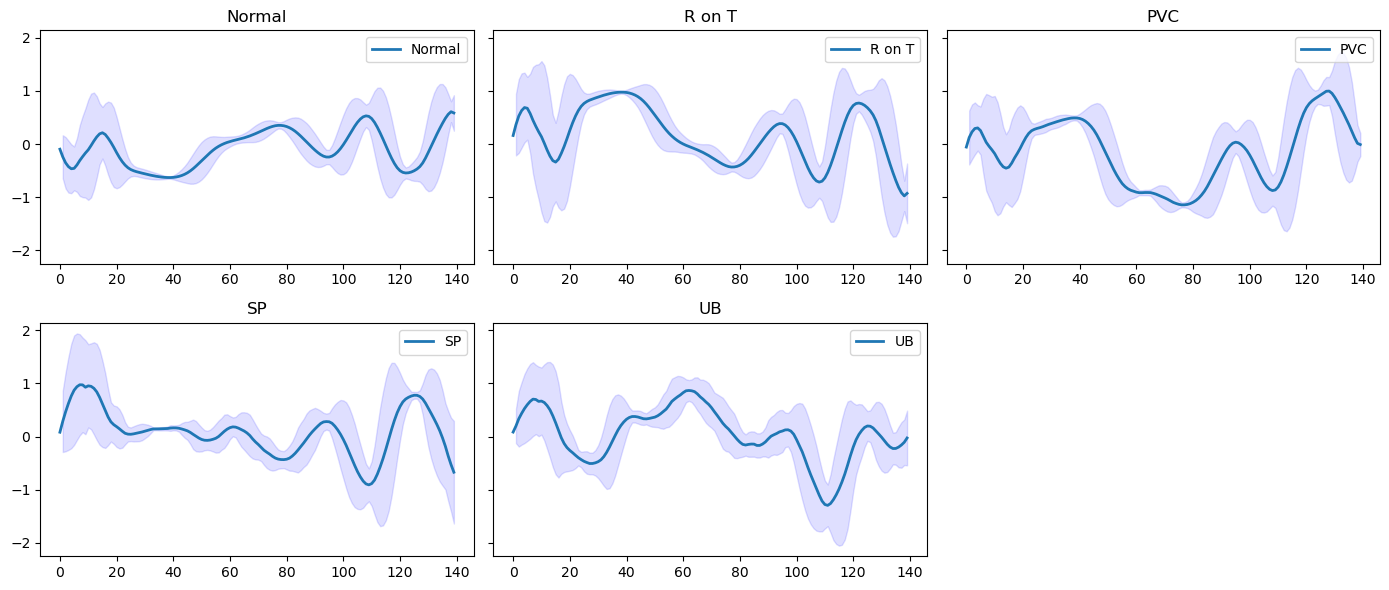

In [130]:
fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 6)
)

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    
    temp_data = normalized_data[normalized_data['target'] == cls].drop(labels='target', axis=1).mean(axis=0).to_numpy()
    
    plot_time_series_class(temp_data, class_names[i], ax)

fig.delaxes(axs.flat[-1])

fig.tight_layout()
plt.show()

In [131]:
data = normalized_data

- datasets:

In [132]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences: np.ndarray):
        """
        :param sequences: NumPy array of shape (n_samples, seq_len)
        """
        self.sequences = [torch.tensor(seq, dtype=torch.float32).unsqueeze(-1) for seq in sequences]  
        self.seq_len = self.sequences[0].shape[0]
        self.n_features = self.sequences[0].shape[1]

    def __len__(self) -> int:
        return len(self.sequences)

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.sequences[idx]

    def get_len(self) -> int:
        return self.seq_len
    

def split_data(data: pd.DataFrame, target_column: str, normal_class: str, test_size=0.2, val_size=0.5, random_state=42):
    normal_data = data[data[target_column] == normal_class].drop(columns=[target_column]).to_numpy()
    anomalies_data = data[data[target_column] != normal_class].drop(columns=[target_column]).to_numpy()

    train_data, test_data = train_test_split(normal_data, test_size=test_size, random_state=random_state)
    val_data, test_data = train_test_split(test_data, test_size=val_size, random_state=random_state)

    return train_data, val_data, test_data, anomalies_data


def create_datasets(train_data, val_data, test_data, anomalies_data):
    train_dataset = TimeSeriesDataset(train_data)
    val_dataset = TimeSeriesDataset(val_data)
    test_normal_dataset = TimeSeriesDataset(test_data)
    test_anomaly_dataset = TimeSeriesDataset(anomalies_data)

    return train_dataset, val_dataset, test_normal_dataset, test_anomaly_dataset

In [133]:
# DATA SPLITS
train_data, val_data, test_data, anomalies_data = split_data(data, target_column="target", normal_class=CLASS_NORMAL)

# DATASETS
train_dataset, val_dataset, test_normal_dataset, test_anomaly_dataset = create_datasets(train_data, val_data, test_data, anomalies_data)

 # DATASET STATS
print(f"Train dataset: {len(train_dataset)} sequences, seq_len={train_dataset.get_len()}")
print(f"Validation dataset: {len(val_dataset)} sequences, seq_len={val_dataset.get_len()}")
print(f"Test normal dataset: {len(test_normal_dataset)} sequences, seq_len={test_normal_dataset.get_len()}")
print(f"Test anomaly dataset: {len(test_anomaly_dataset)} sequences, seq_len={test_anomaly_dataset.get_len()}")

Train dataset: 2335 sequences, seq_len=140
Validation dataset: 292 sequences, seq_len=140
Test normal dataset: 292 sequences, seq_len=140
Test anomaly dataset: 2081 sequences, seq_len=140


In [134]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

### Autoencoder architecture

In [135]:
class Encoder(nn.Module):
    def __init__(self, seq_len: int, n_features: int, embedding_dim: int = 64):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=2 * embedding_dim, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=2 * embedding_dim, hidden_size=embedding_dim, num_layers=1, batch_first=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        return x[:, -1, :]  # Return last hidden state

In [136]:
class Decoder(nn.Module):
    def __init__(self, seq_len: int, input_dim: int = 64, n_features: int = 1):
        super().__init__()
        self.seq_len = seq_len
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=2 * input_dim, num_layers=1, batch_first=True)
        self.output_layer = nn.Linear(2 * input_dim, n_features)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)  # Repeat across time steps
        x, _ = self.lstm(x)
        return self.output_layer(x)  # Output shape: (batch_size, seq_len, n_features)

In [137]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len: int, n_features: int, embedding_dim: int = 64):
        super().__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim)
        self.decoder = Decoder(seq_len, embedding_dim, n_features)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [138]:
model = RecurrentAutoencoder(seq_len=train_dataset.get_len(), n_features=train_dataset.n_features, embedding_dim=128)
model = model.to(device)
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (lstm1): LSTM(1, 256, batch_first=True)
    (lstm2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

### Training

In [139]:
def train_model(model, train_loader, val_loader, n_epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss(reduction='sum').to(device)
    history = {"train": [], "val": []}

    for epoch in tqdm(range(1, n_epochs + 1)):
        model.train()
        train_loss = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            seq_pred = model(batch)
            loss = criterion(seq_pred, batch) 
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                seq_pred = model(batch)
                loss = criterion(seq_pred, batch)
                val_loss += loss.item()

        val_loss /= len(val_loader.dataset)
        history["train"].append(train_loss)
        history["val"].append(val_loss)

        print(f"Epoch {epoch}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")

    return model.eval(), history

In [140]:
model2, history2 = train_model(
    model,
    train_loader,  
    val_loader,    
    n_epochs=100)

  1%|          | 1/100 [00:06<11:26,  6.93s/it]

Epoch 1: train loss 111.5070, val loss 100.0153


  2%|▏         | 2/100 [00:13<11:12,  6.87s/it]

Epoch 2: train loss 109.7634, val loss 98.2779


  3%|▎         | 3/100 [00:20<11:00,  6.81s/it]

Epoch 3: train loss 101.5325, val loss 73.2029


  4%|▍         | 4/100 [00:27<10:59,  6.87s/it]

Epoch 4: train loss 79.6508, val loss 64.7641


  5%|▌         | 5/100 [00:34<10:54,  6.89s/it]

Epoch 5: train loss 73.3823, val loss 64.0333


  6%|▌         | 6/100 [00:41<10:41,  6.82s/it]

Epoch 6: train loss 66.8450, val loss 56.3641


  7%|▋         | 7/100 [00:47<10:37,  6.85s/it]

Epoch 7: train loss 59.6537, val loss 58.6834


  8%|▊         | 8/100 [00:54<10:29,  6.84s/it]

Epoch 8: train loss 55.9364, val loss 49.7311


  9%|▉         | 9/100 [01:01<10:19,  6.81s/it]

Epoch 9: train loss 52.7098, val loss 42.6997


 10%|█         | 10/100 [01:08<10:20,  6.90s/it]

Epoch 10: train loss 48.2233, val loss 44.4812


 11%|█         | 11/100 [01:15<10:06,  6.81s/it]

Epoch 11: train loss 42.9757, val loss 34.0765


 12%|█▏        | 12/100 [01:22<09:58,  6.80s/it]

Epoch 12: train loss 38.7282, val loss 33.0452


 13%|█▎        | 13/100 [01:28<09:49,  6.77s/it]

Epoch 13: train loss 36.0779, val loss 31.0809


 14%|█▍        | 14/100 [01:35<09:40,  6.75s/it]

Epoch 14: train loss 34.4789, val loss 38.9572


 15%|█▌        | 15/100 [01:42<09:34,  6.76s/it]

Epoch 15: train loss 32.9496, val loss 27.5677


 16%|█▌        | 16/100 [01:48<09:28,  6.76s/it]

Epoch 16: train loss 31.3743, val loss 24.6594


 17%|█▋        | 17/100 [01:56<09:30,  6.87s/it]

Epoch 17: train loss 29.2811, val loss 23.4676


 18%|█▊        | 18/100 [02:02<09:23,  6.87s/it]

Epoch 18: train loss 28.1378, val loss 21.7492


 19%|█▉        | 19/100 [02:10<09:23,  6.96s/it]

Epoch 19: train loss 26.7575, val loss 24.9854


 20%|██        | 20/100 [02:16<09:11,  6.90s/it]

Epoch 20: train loss 26.9429, val loss 21.9860


 21%|██        | 21/100 [02:23<09:05,  6.91s/it]

Epoch 21: train loss 25.5444, val loss 19.1497


 22%|██▏       | 22/100 [02:30<08:51,  6.81s/it]

Epoch 22: train loss 24.6446, val loss 19.5184


 23%|██▎       | 23/100 [02:37<08:44,  6.81s/it]

Epoch 23: train loss 23.8141, val loss 18.4065


 24%|██▍       | 24/100 [02:44<08:38,  6.83s/it]

Epoch 24: train loss 24.8648, val loss 18.1381


 25%|██▌       | 25/100 [02:50<08:29,  6.79s/it]

Epoch 25: train loss 22.3841, val loss 17.7220


 26%|██▌       | 26/100 [02:57<08:29,  6.88s/it]

Epoch 26: train loss 23.1854, val loss 19.9124


 27%|██▋       | 27/100 [03:04<08:21,  6.87s/it]

Epoch 27: train loss 23.6424, val loss 21.1255


 28%|██▊       | 28/100 [03:11<08:11,  6.83s/it]

Epoch 28: train loss 22.9533, val loss 17.3416


 29%|██▉       | 29/100 [03:18<08:04,  6.83s/it]

Epoch 29: train loss 20.8072, val loss 16.4637


 30%|███       | 30/100 [03:25<07:59,  6.85s/it]

Epoch 30: train loss 20.9909, val loss 16.7212


 31%|███       | 31/100 [03:32<07:52,  6.85s/it]

Epoch 31: train loss 20.4589, val loss 15.6881


 32%|███▏      | 32/100 [03:39<07:51,  6.94s/it]

Epoch 32: train loss 19.8934, val loss 15.1804


 33%|███▎      | 33/100 [03:45<07:35,  6.80s/it]

Epoch 33: train loss 19.5164, val loss 14.8762


 34%|███▍      | 34/100 [03:52<07:27,  6.79s/it]

Epoch 34: train loss 20.0696, val loss 16.0849


 35%|███▌      | 35/100 [03:59<07:18,  6.74s/it]

Epoch 35: train loss 19.9513, val loss 14.1416


 36%|███▌      | 36/100 [04:06<07:21,  6.90s/it]

Epoch 36: train loss 19.0548, val loss 14.1306


 37%|███▋      | 37/100 [04:13<07:24,  7.06s/it]

Epoch 37: train loss 18.4187, val loss 14.0923


 38%|███▊      | 38/100 [04:20<07:17,  7.06s/it]

Epoch 38: train loss 17.5536, val loss 14.0714


 39%|███▉      | 39/100 [04:27<07:05,  6.98s/it]

Epoch 39: train loss 18.2870, val loss 14.4220


 40%|████      | 40/100 [04:34<07:00,  7.01s/it]

Epoch 40: train loss 17.6923, val loss 14.0803


 41%|████      | 41/100 [04:41<06:54,  7.02s/it]

Epoch 41: train loss 17.5095, val loss 13.4987


 42%|████▏     | 42/100 [04:48<06:47,  7.03s/it]

Epoch 42: train loss 17.4169, val loss 13.1423


 43%|████▎     | 43/100 [04:55<06:38,  6.98s/it]

Epoch 43: train loss 16.7490, val loss 14.5447


 44%|████▍     | 44/100 [05:02<06:26,  6.91s/it]

Epoch 44: train loss 16.4016, val loss 12.9010


 45%|████▌     | 45/100 [05:09<06:19,  6.91s/it]

Epoch 45: train loss 17.2545, val loss 12.4047


 46%|████▌     | 46/100 [05:16<06:15,  6.94s/it]

Epoch 46: train loss 16.3355, val loss 12.7210


 47%|████▋     | 47/100 [05:23<06:04,  6.88s/it]

Epoch 47: train loss 16.7956, val loss 12.4774


 48%|████▊     | 48/100 [05:30<06:07,  7.07s/it]

Epoch 48: train loss 15.9246, val loss 16.7019


 49%|████▉     | 49/100 [05:38<06:19,  7.44s/it]

Epoch 49: train loss 16.2077, val loss 12.6638


 50%|█████     | 50/100 [05:46<06:10,  7.41s/it]

Epoch 50: train loss 15.5534, val loss 12.0721


 51%|█████     | 51/100 [05:53<06:06,  7.47s/it]

Epoch 51: train loss 15.4049, val loss 11.6631


 52%|█████▏    | 52/100 [06:01<06:02,  7.56s/it]

Epoch 52: train loss 15.1325, val loss 14.7799


 53%|█████▎    | 53/100 [06:09<05:52,  7.51s/it]

Epoch 53: train loss 16.1331, val loss 23.8597


 54%|█████▍    | 54/100 [06:15<05:35,  7.29s/it]

Epoch 54: train loss 15.9339, val loss 11.8320


 55%|█████▌    | 55/100 [06:22<05:24,  7.20s/it]

Epoch 55: train loss 14.5829, val loss 12.4931


 56%|█████▌    | 56/100 [06:29<05:11,  7.09s/it]

Epoch 56: train loss 14.9694, val loss 13.0914


 57%|█████▋    | 57/100 [06:36<04:57,  6.93s/it]

Epoch 57: train loss 36.4174, val loss 61.1037


 58%|█████▊    | 58/100 [06:43<04:53,  6.99s/it]

Epoch 58: train loss 41.8148, val loss 22.8352


 59%|█████▉    | 59/100 [06:49<04:42,  6.90s/it]

Epoch 59: train loss 25.5810, val loss 19.9028


 60%|██████    | 60/100 [06:56<04:34,  6.86s/it]

Epoch 60: train loss 21.4430, val loss 16.3686


 61%|██████    | 61/100 [07:03<04:26,  6.84s/it]

Epoch 61: train loss 20.5526, val loss 14.9140


 62%|██████▏   | 62/100 [07:10<04:20,  6.86s/it]

Epoch 62: train loss 18.5350, val loss 14.3689


 63%|██████▎   | 63/100 [07:17<04:12,  6.82s/it]

Epoch 63: train loss 18.0373, val loss 13.8419


 64%|██████▍   | 64/100 [07:24<04:09,  6.92s/it]

Epoch 64: train loss 17.0694, val loss 13.2956


 65%|██████▌   | 65/100 [07:31<04:00,  6.87s/it]

Epoch 65: train loss 16.1689, val loss 35.5703


 66%|██████▌   | 66/100 [07:37<03:53,  6.86s/it]

Epoch 66: train loss 31.0405, val loss 15.0057


 67%|██████▋   | 67/100 [07:44<03:46,  6.86s/it]

Epoch 67: train loss 20.0114, val loss 14.0845


 68%|██████▊   | 68/100 [07:51<03:38,  6.82s/it]

Epoch 68: train loss 18.0513, val loss 12.4774


 69%|██████▉   | 69/100 [07:58<03:33,  6.90s/it]

Epoch 69: train loss 16.8092, val loss 12.6452


 70%|███████   | 70/100 [08:05<03:24,  6.83s/it]

Epoch 70: train loss 16.1348, val loss 13.4709


 71%|███████   | 71/100 [08:11<03:16,  6.79s/it]

Epoch 71: train loss 15.6015, val loss 13.2530


 72%|███████▏  | 72/100 [08:18<03:10,  6.79s/it]

Epoch 72: train loss 15.4893, val loss 11.6315


 73%|███████▎  | 73/100 [08:25<03:02,  6.77s/it]

Epoch 73: train loss 15.0955, val loss 11.1639


 74%|███████▍  | 74/100 [08:32<02:59,  6.90s/it]

Epoch 74: train loss 14.7379, val loss 12.8252


 75%|███████▌  | 75/100 [08:39<02:52,  6.90s/it]

Epoch 75: train loss 15.3247, val loss 11.2819


 76%|███████▌  | 76/100 [08:46<02:44,  6.84s/it]

Epoch 76: train loss 15.2899, val loss 11.3657


 77%|███████▋  | 77/100 [08:52<02:35,  6.78s/it]

Epoch 77: train loss 14.6364, val loss 11.3430


 78%|███████▊  | 78/100 [08:59<02:28,  6.77s/it]

Epoch 78: train loss 14.0545, val loss 11.7694


 79%|███████▉  | 79/100 [09:06<02:21,  6.75s/it]

Epoch 79: train loss 14.4471, val loss 10.7782


 80%|████████  | 80/100 [09:13<02:16,  6.82s/it]

Epoch 80: train loss 14.3116, val loss 11.4985


 81%|████████  | 81/100 [09:20<02:09,  6.82s/it]

Epoch 81: train loss 14.1143, val loss 12.7870


 82%|████████▏ | 82/100 [09:28<02:12,  7.35s/it]

Epoch 82: train loss 13.6344, val loss 10.6071


 83%|████████▎ | 83/100 [09:35<02:04,  7.31s/it]

Epoch 83: train loss 13.8832, val loss 9.7831


 84%|████████▍ | 84/100 [09:43<01:59,  7.48s/it]

Epoch 84: train loss 13.8051, val loss 9.8679


 85%|████████▌ | 85/100 [09:51<01:54,  7.64s/it]

Epoch 85: train loss 12.7564, val loss 10.8082


 86%|████████▌ | 86/100 [09:59<01:45,  7.52s/it]

Epoch 86: train loss 13.0545, val loss 10.4532


 87%|████████▋ | 87/100 [10:05<01:33,  7.21s/it]

Epoch 87: train loss 13.6592, val loss 9.7600


 88%|████████▊ | 88/100 [10:12<01:25,  7.09s/it]

Epoch 88: train loss 13.4034, val loss 9.6459


 89%|████████▉ | 89/100 [10:18<01:16,  6.94s/it]

Epoch 89: train loss 12.8187, val loss 15.2571


 90%|█████████ | 90/100 [10:25<01:08,  6.83s/it]

Epoch 90: train loss 13.6908, val loss 10.1595


 91%|█████████ | 91/100 [10:32<01:02,  6.89s/it]

Epoch 91: train loss 12.2358, val loss 9.3210


 92%|█████████▏| 92/100 [10:39<00:54,  6.85s/it]

Epoch 92: train loss 11.8901, val loss 11.5475


 93%|█████████▎| 93/100 [10:46<00:47,  6.82s/it]

Epoch 93: train loss 12.2457, val loss 9.5938


 94%|█████████▍| 94/100 [10:52<00:40,  6.77s/it]

Epoch 94: train loss 12.5791, val loss 9.4540


 95%|█████████▌| 95/100 [10:59<00:33,  6.69s/it]

Epoch 95: train loss 12.7696, val loss 12.8077


 96%|█████████▌| 96/100 [11:06<00:27,  6.76s/it]

Epoch 96: train loss 13.1881, val loss 8.8808


 97%|█████████▋| 97/100 [11:13<00:20,  6.96s/it]

Epoch 97: train loss 11.6302, val loss 9.4692


 98%|█████████▊| 98/100 [11:21<00:14,  7.39s/it]

Epoch 98: train loss 11.2586, val loss 8.7894


 99%|█████████▉| 99/100 [11:29<00:07,  7.27s/it]

Epoch 99: train loss 11.4288, val loss 11.0873


100%|██████████| 100/100 [11:36<00:00,  6.96s/it]

Epoch 100: train loss 11.6120, val loss 8.7512


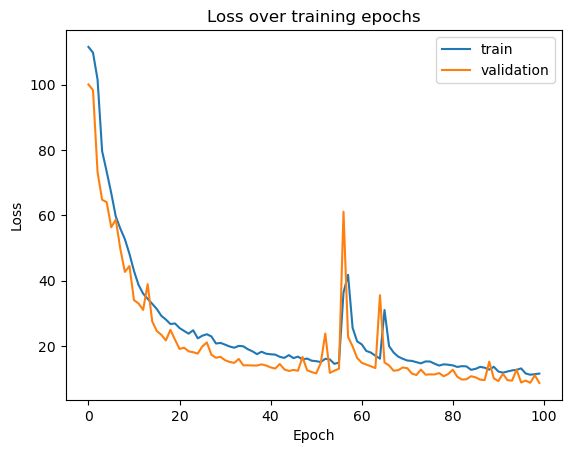

In [141]:
ax = plt.figure().gca()

ax.plot(history2['train'])
ax.plot(history2['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.title('Loss over training epochs')
plt.show()

In [143]:
MODEL_PATH = 'model.pth'

torch.save(model2, MODEL_PATH)

### Threshold selection

In [153]:
model = torch.load(MODEL_PATH, map_location=device, weights_only=False)
model = model.to(device)
model.eval()

RecurrentAutoencoder(
  (encoder): Encoder(
    (lstm1): LSTM(1, 256, batch_first=True)
    (lstm2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [161]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.MSELoss(reduction='none')

    with torch.no_grad():
        model.eval()
        for seq_true in dataset:
            seq_true = seq_true.unsqueeze(0).to(device)  # batch_size=1

            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.mean().item())  

    return predictions, losses


In [162]:
_, train_losses = predict(model, train_dataset)

d:\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


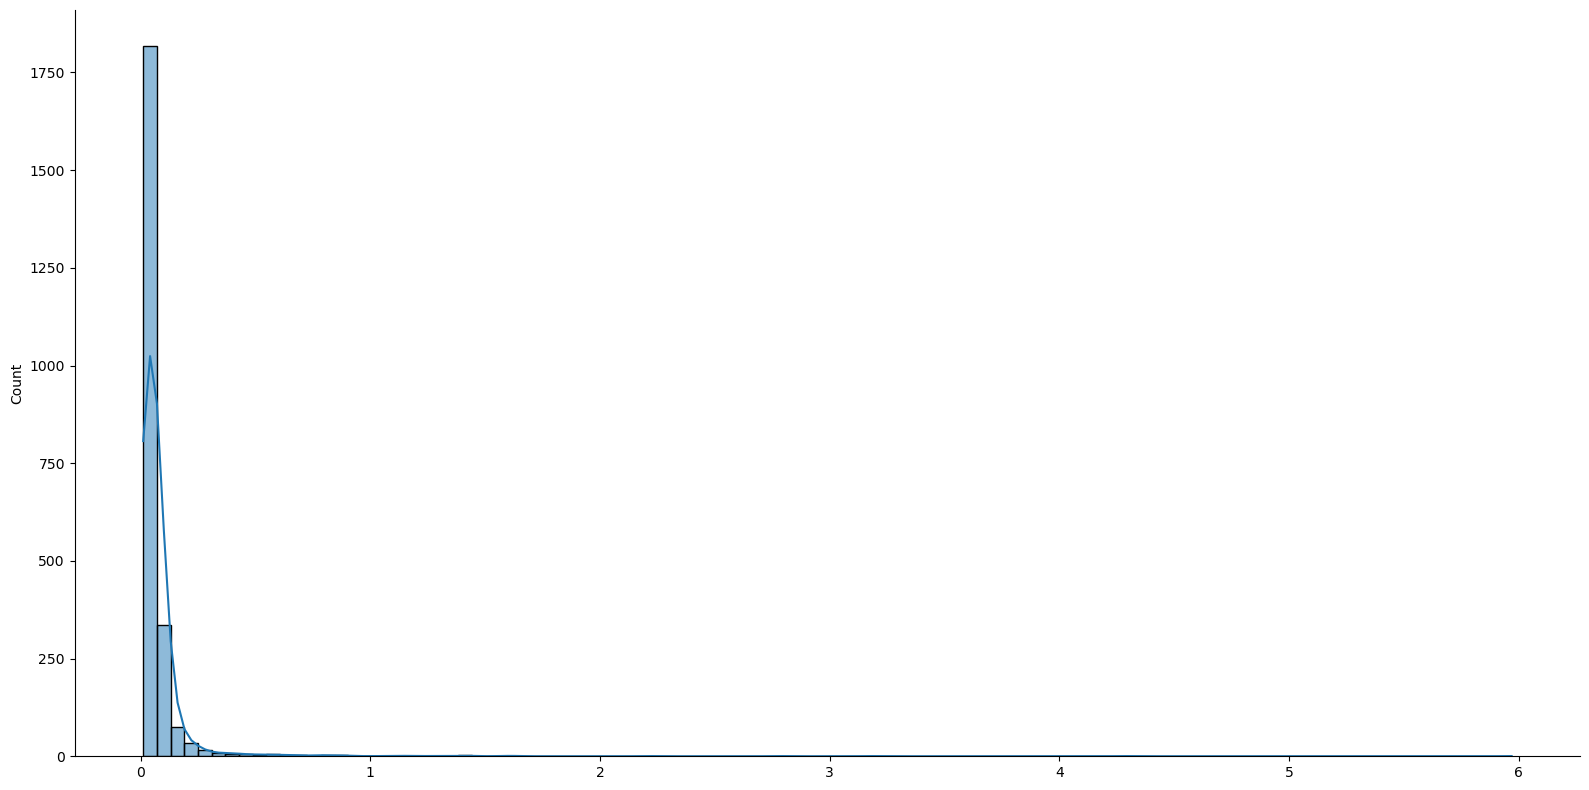

In [175]:
sns.displot(train_losses, bins=100, kde=True, aspect=2, height=8)
plt.show()

In [195]:
THRESHOLD = 0.3

### Evaluation

- Nomral heartbeats test set:

d:\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


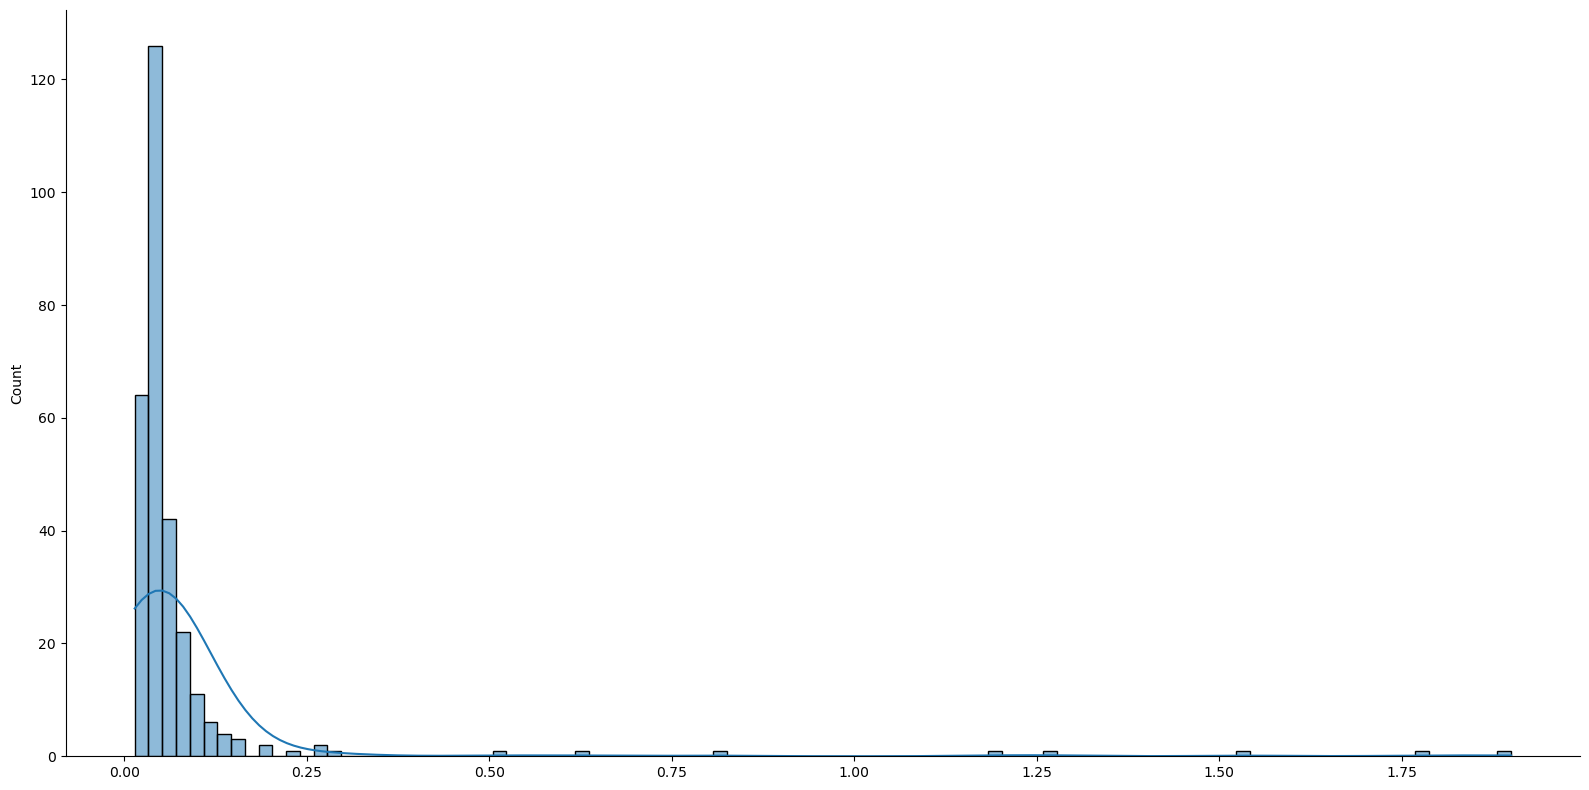

In [203]:
_, normal_losses = predict(model, test_normal_dataset)
sns.displot(normal_losses, bins=100, kde=True, aspect=2, height=8)

In [204]:
correct = sum(l <= THRESHOLD for l in normal_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 284/292


- anomalies data:

d:\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


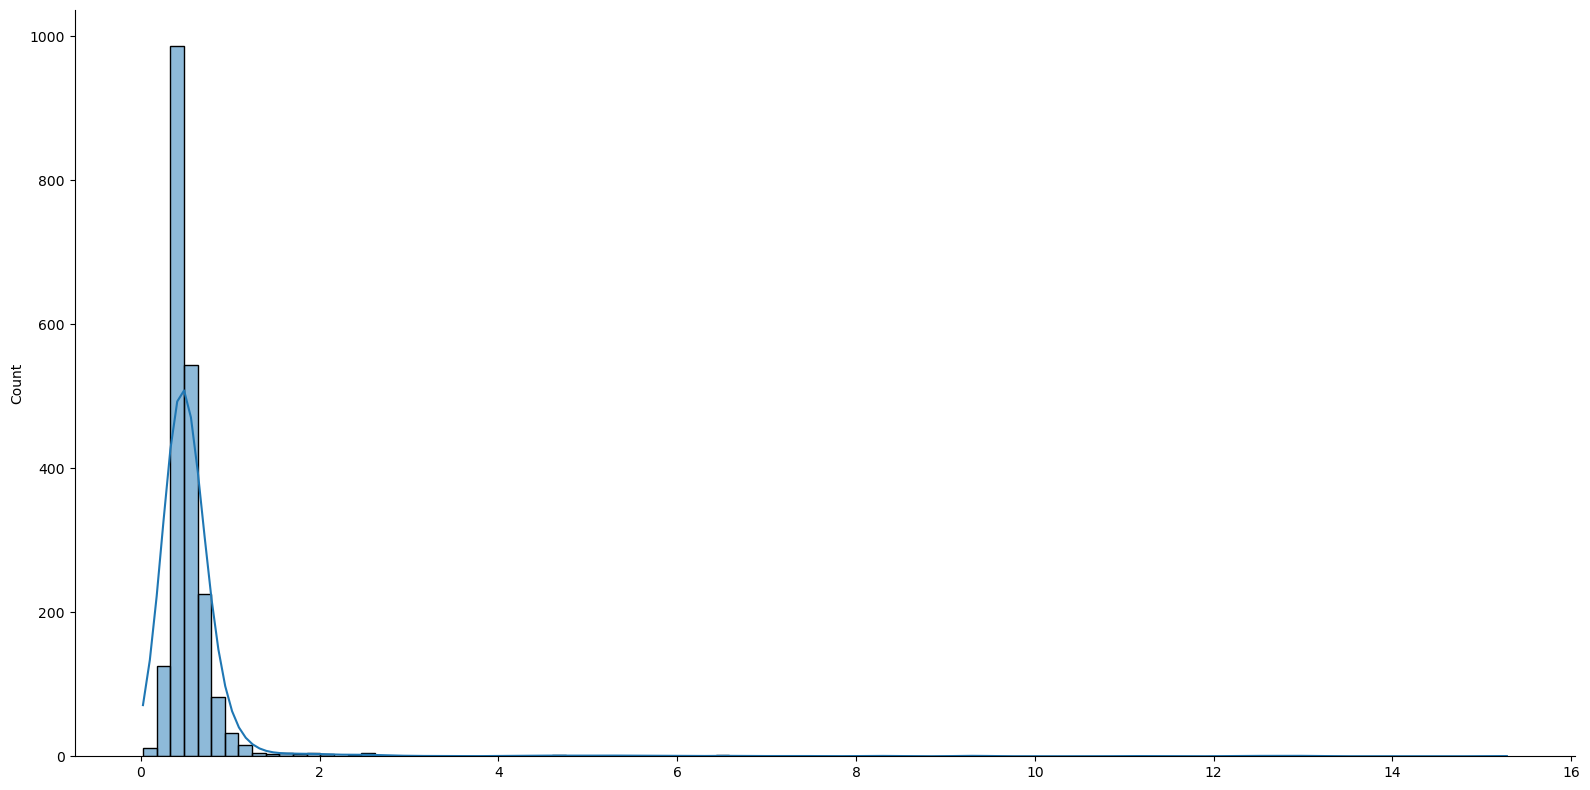

In [205]:
_, anomaly_losses = predict(model, test_anomaly_dataset)
sns.displot(anomaly_losses, bins=100, kde=True, aspect=2, height=8)

In [206]:
correct = sum(l > THRESHOLD for l in anomaly_losses)
print(f'Correct anomaly predictions: {correct}/{len(test_anomaly_dataset)}')

Correct anomaly predictions: 2016/2081


- confusion matrix:

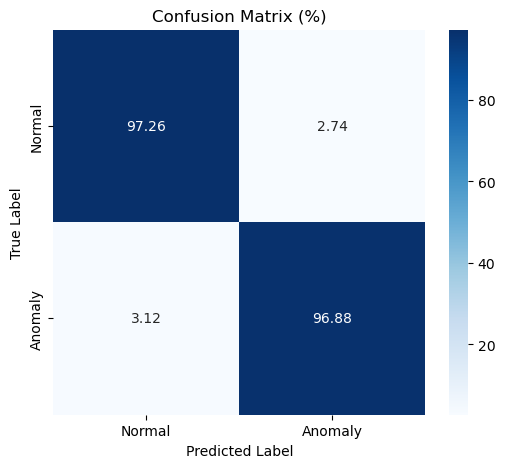

In [207]:
y_true = [0] * len(normal_losses) + [1] * len(anomaly_losses)  # 0 = normal, 1 = anomalies
y_pred = [1 if l > THRESHOLD else 0 for l in normal_losses] + [1 if l > THRESHOLD else 0 for l in anomaly_losses]

cm = confusion_matrix(y_true, y_pred)

cm_percent = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True) * 100 

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (%)")
plt.show()

In [208]:
report = classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"])
print(report)

              precision    recall  f1-score   support

      Normal       0.81      0.97      0.89       292
     Anomaly       1.00      0.97      0.98      2081

    accuracy                           0.97      2373
   macro avg       0.90      0.97      0.93      2373
weighted avg       0.97      0.97      0.97      2373



- examples:

In [209]:
def plot_prediction(data, model, title, ax):
  pred, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(pred[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

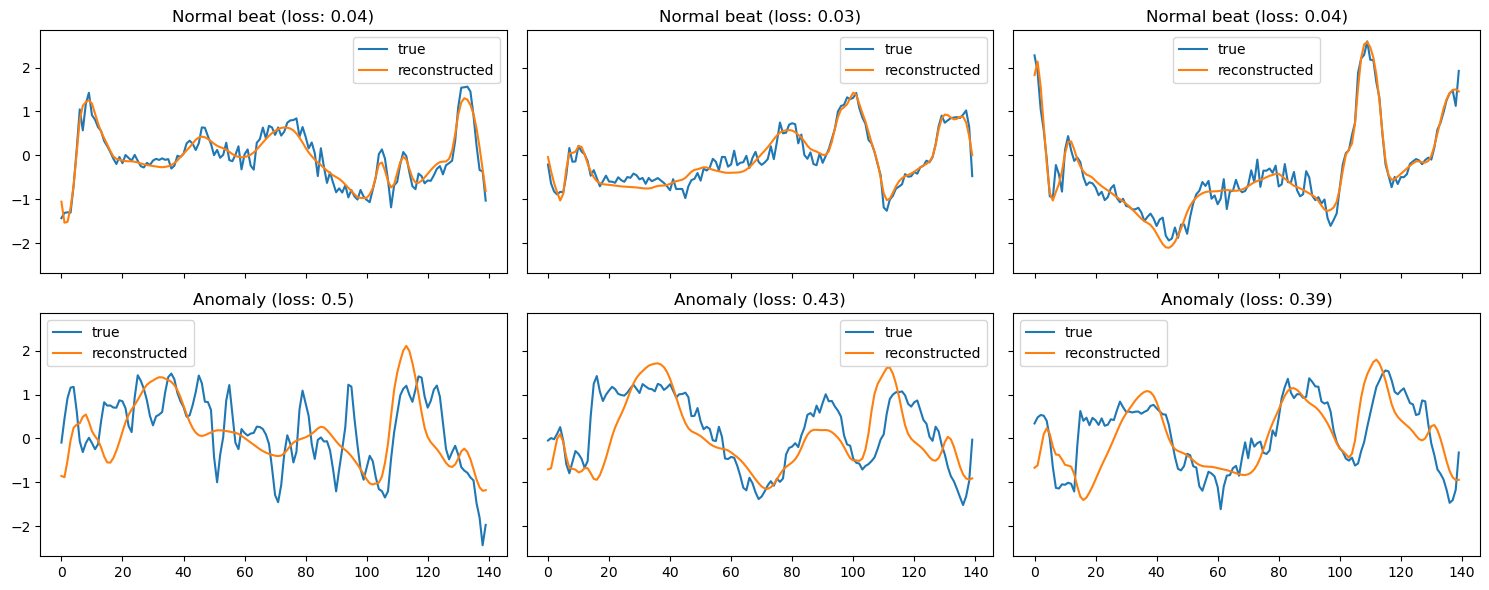

In [213]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=3,
  sharey=True,
  sharex=True,
  figsize=(15, 6)
)

for i, data in enumerate(test_normal_dataset[:3]):
  plot_prediction(data, model, title='Normal beat', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:3]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout()